In [1]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler, StandardScaler # min/max scaling
import pickle
import seaborn as sns
from matplotlib.colors import LogNorm
from MAPseq_processing import * # import all functions from this script
from MAPseq_plotting import * # import all functions from this script
import matplotlib.lines as mlines # needed for custom legend
from scipy import stats
import random

# for upset plots
from itertools import combinations, chain
from upsetplot import from_memberships
from math import comb
import upsetplot


# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp

%matplotlib inline

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2


In [3]:

# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
out_path = '/Volumes/Data/Emily/figures/fig_3_sc/python_out/'

#### load data
with open(in_path +'M194_M220_OMC_bin4.pkl', 'rb') as f:
    omc_bin = pickle.load(f)   

#### load data
with open(in_path +'M194_M220_OMC_countN4.pkl', 'rb') as f:
    omc_countN = pickle.load(f)

In [5]:
# initial processing
# bin processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

metadata


,mice,species,sex,dataset
0,MMM1,MMus,male,M194
1,MMF2,MMus,female,M194
2,MMF3,MMus,female,M194
3,STM1,STeg,male,M194
4,STM2,STeg,male,M194
5,STF3,STeg,female,M194
6,MMM4,MMus,male,M220
7,MMF5,MMus,female,M220
8,STF4,STeg,female,M220
9,STM5,STeg,male,M220


# motif plots

In [15]:

# seperate it cells
omc_it = [df[df['type']=="IT"] for df in omc_type]

# seperate pt cells
omc_pt = [df[df['type']=="PT"] for df in omc_type]

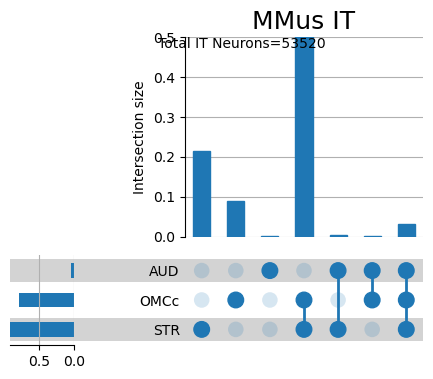

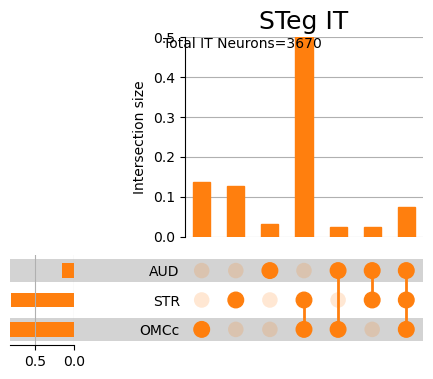

In [18]:
plot_areas = ["OMCc", "AUD", "STR"]


# plot mmus
mm_it = []
for i in range(metadata.shape[0]):
    if metadata.loc[i,"species"] == "MMus":
        mm_it.append(omc_it[i])

mm_it_all = pd.concat(mm_it)

plot = df_to_motif_proportion(mm_it_all, areas=plot_areas, proportion=True)
upset_plot(plot, title="MMus IT", suptitle="Total IT Neurons="+str(mm_it_all.shape[0]))
# plt.suptitle("Total PAG Neurons="+str(mm_pag.shape[0]), x=0.56, y=0.88, fontsize=10)
plt.show()

# plot STeg
st_it = []
for i in range(metadata.shape[0]):
    if metadata.loc[i,"species"] == "STeg":
        st_it.append(omc_it[i])

st_it_all = pd.concat(st_it)

plot = df_to_motif_proportion(st_it_all, areas=plot_areas, proportion=True)
upset_plot(plot, title="STeg IT", suptitle="Total IT Neurons="+str(st_it_all.shape[0]), facecolor="tab:orange")
# plt.suptitle("Total PAG Neurons="+str(mm_pag.shape[0]), x=0.56, y=0.88, fontsize=10)
plt.show()



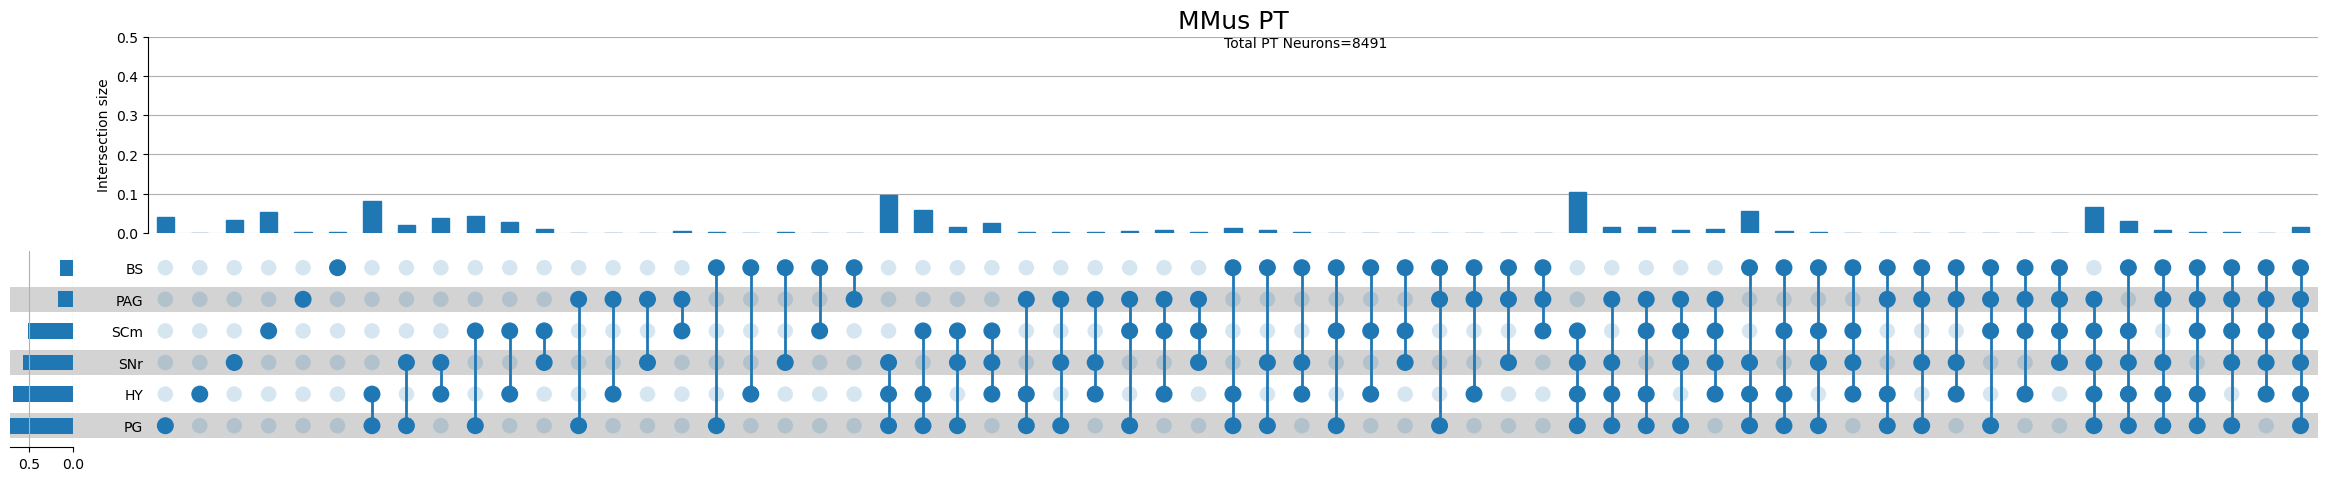

In [19]:
plot_areas = ["BS", "SNr", "SCm", "PG", "HY", "PAG"]

# plot mmus
mm_pt = []
for i in range(metadata.shape[0]):
    if metadata.loc[i,"species"] == "MMus":
        mm_pt.append(omc_pt[i])

mm_pt_all = pd.concat(mm_pt)

plot = df_to_motif_proportion(mm_pt_all, areas=plot_areas, proportion=True)
upset_plot(plot, title="MMus PT", suptitle="Total PT Neurons="+str(mm_pt_all.shape[0]))
# plt.suptitle("Total PAG Neurons="+str(mm_pag.shape[0]), x=0.56, y=0.88, fontsize=10)
plt.show()

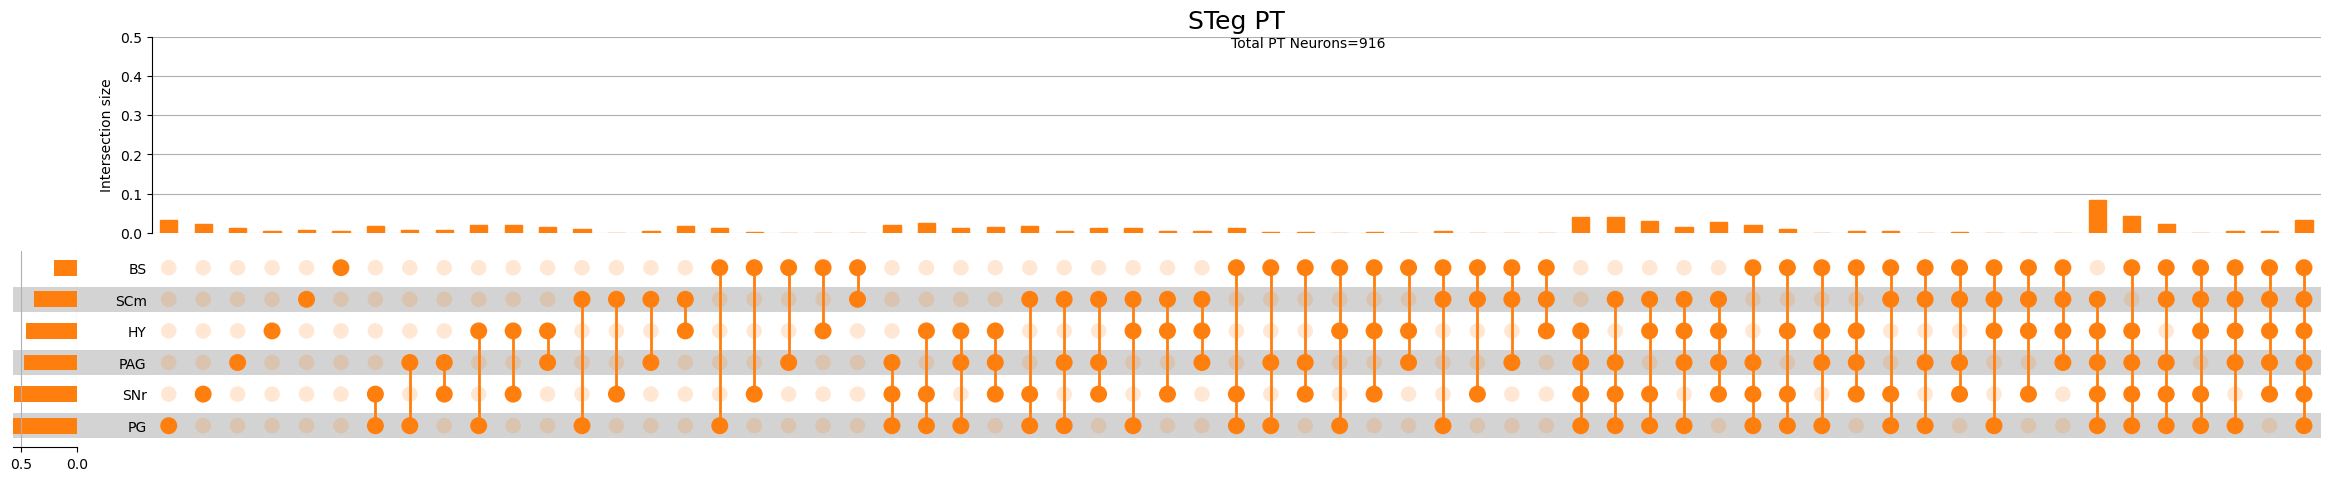

In [20]:

# plot STeg
st_pt = []
for i in range(metadata.shape[0]):
    if metadata.loc[i,"species"] == "STeg":
        st_pt.append(omc_pt[i])

st_pt_all = pd.concat(st_pt)

plot = df_to_motif_proportion(st_pt_all, areas=plot_areas, proportion=True)
upset_plot(plot, title="STeg PT", suptitle="Total PT Neurons="+str(st_pt_all.shape[0]), facecolor="tab:orange")
# plt.suptitle("Total PAG Neurons="+str(mm_pag.shape[0]), x=0.56, y=0.88, fontsize=10)
plt.show()



# Volcano motif plot

In [175]:
st_pt_motif_prop = df_to_motif_proportion(st_pt_all, areas=plot_areas, proportion=True)

# calculate proportion for each area (sum/tot)
st_pt_prop = st_pt_all.sum()[plot_areas]/st_pt_all.shape[0]

# multiply by T/F where false --> 1???

st_pt_mult = [x * st_pt_prop for x in st_pt_motif_prop.index]
st_pt_mult = np.array(st_pt_mult)
st_pt_mult[st_pt_mult==0.0] = 1

exp = np.prod(st_pt_mult, axis=1)

# turn into data frame
end = pd.DataFrame()
end['obs'] = st_pt_motif_prop.values
end['exp'] = exp
end

,obs,exp
0,0.004367,0.208515
1,0.005459,0.459607
2,0.013100,0.471616
3,0.032751,0.568777
4,0.007642,0.382096
...,...,...
58,0.005459,0.00971
59,0.001092,0.01171
60,0.022926,0.012016
61,0.084061,0.026485


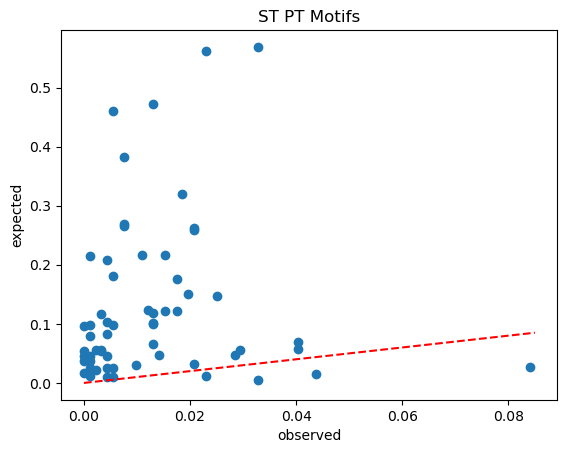

In [176]:
xy = np.linspace(0,0.085,5)
plt.scatter(end['obs'], end['exp'])
plt.plot(xy, xy, color='red', linestyle='--')
plt.xlabel("observed")
plt.ylabel("expected")
plt.title("ST PT Motifs")
plt.show()

In [179]:
# binomial test
import scipy.stats as stats

st_n = st_pt_all.shape[0]

# Define your observed and expected fractions as arrays
observed_fractions = end['obs']  # Replace with your observed fractions
expected_fractions = end['exp']   # Replace with your expected fractions

# Perform a binomial test for each pair of observed and expected fractions
p_values = [stats.binom_test(obs * st_n, n=st_n, p=exp) for obs, exp in zip(observed_fractions, expected_fractions)]

# Apply Bonferroni correction to the p-values
alpha = 0.05  # Set your desired significance level
bonferroni_corrected = alpha / len(p_values)

# Check if any p-value is less than the Bonferroni corrected threshold
significant_results = [p < bonferroni_corrected for p in p_values]

# Print the original p-values and significant results
print("Original p-values:", p_values)
print("Bonferroni corrected threshold:", bonferroni_corrected)
print("Significant results:", significant_results)


end['log2_fc'] = [np.log2(o/e) for o, e in zip(end['obs'], end['exp'])]
end['p_value'] = p_values
end['nlog10_p'] = np.log10(end['p_value']+0.0001)*-1

# add labels
pt_tf = st_pt_motif_prop.index.values

labels = st_pt_motif_prop.index.names

fin_labels = []
for i in range(len(pt_tf)):
    result = [t * a for t, a in zip(pt_tf[i], labels)]
    fin_labels.append(result)

end['labels'] = fin_labels
end
end


Original p-values: [1.9515777610864687e-85, 3.8172488264539554e-233, 3.559810331272916e-228, 0.0, 1.5501302840314004e-176, 0.0, 1.979413114662234e-40, 1.3080930998220143e-39, 2.7190389810154893e-34, 1.3218431525280993e-31, 1.6995505329403105e-44, 6.01813700344484e-75, 1.6114324575631868e-90, 6.816544107143332e-54, 5.256274329902896e-89, 9.490386349386881e-111, 5.88431502249643e-70, 4.275308260702073e-109, 1.5472320035606115e-80, 1.4539097723122231e-123, 3.2127408580543354e-94, 8.138809660652918e-19, 1.2103724374879487e-22, 3.582339221003222e-15, 4.361485437168818e-18, 6.205558420539985e-19, 4.565152167787094e-14, 7.484962671135108e-20, 1.2244383849323967e-13, 9.090052622814932e-15, 6.39998804892588e-17, 2.947379100875489e-37, 1.3379797786743656e-28, 1.0640635717703864e-33, 6.47948981985874e-27, 1.390247905721609e-35, 9.089339976453903e-34, 8.53580794649022e-37, 1.368151264672538e-41, 2.0023230464571227e-27, 6.260395749748218e-32, 1.899738627751486e-09, 2.967686038281694e-07, 1.61514682

/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_93311/3208593839.py:26: RuntimeWarning:

divide by zero encountered in log2



,obs,exp,log2_fc,p_value,nlog10_p,labels
0,0.004367,0.208515,-5.577429,1.951578e-85,4.000000,"[BS, , , , , ]"
1,0.005459,0.459607,-6.395748,3.817249e-233,4.000000,"[, HY, , , , ]"
2,0.013100,0.471616,-5.169925,3.559810e-228,4.000000,"[, , PAG, , , ]"
3,0.032751,0.568777,-4.118249,0.000000e+00,4.000000,"[, , , PG, , ]"
4,0.007642,0.382096,-5.643856,1.550130e-176,4.000000,"[, , , , SCm, ]"
...,...,...,...,...,...,...
58,0.005459,0.00971,-0.830889,2.366602e-01,0.625691,"[BS, HY, PAG, , SCm, SNr]"
59,0.001092,0.01171,-3.423069,5.419147e-04,3.192523,"[BS, HY, , PG, SCm, SNr]"
60,0.022926,0.012016,0.932037,5.603903e-03,2.243828,"[BS, , PAG, PG, SCm, SNr]"
61,0.084061,0.026485,1.666258,2.608292e-18,4.000000,"[, HY, PAG, PG, SCm, SNr]"


<AxesSubplot: title={'center': 'ST PT'}, xlabel='log2(fold change)', ylabel='-log10(p-value)'>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/Users/eisko/miniconda3/envs/MAPseq/lib/python3.10/site-packages/matplotlib/transforms.py:365: RuntimeWarning:

invalid value encountered in double_scalars

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


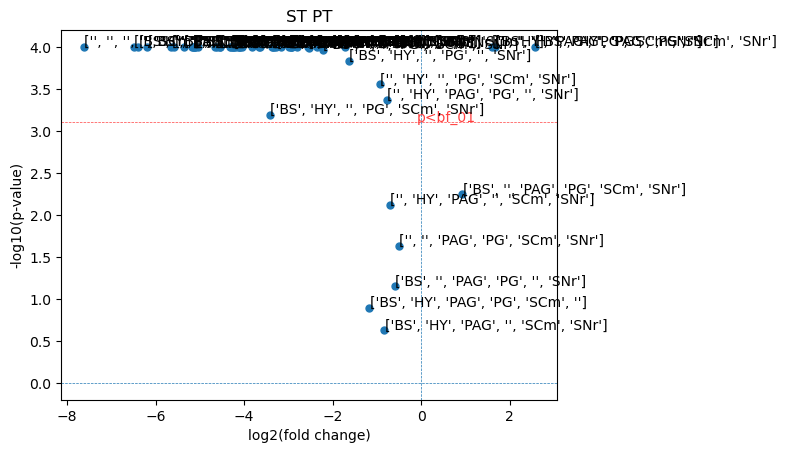

In [180]:
proportion_volcano_plot(end, title="ST PT", labels="labels", p_bf=bonferroni_corrected, p_05=False, p_01=False)

In [155]:


it_plot_areas = ["OMCc", "AUD", "STR"]

st_it_motif_prop = df_to_motif_proportion(st_it_all, areas=it_plot_areas, proportion=True)


# calculate proportion for each area (sum/tot)
st_it_prop = st_it_all.sum()[it_plot_areas]/st_it_all.shape[0]

# multiply by T/F where false --> 1???

st_it_mult = [x * st_it_prop for x in st_it_motif_prop.index]


st_it_mult = np.array(st_it_mult)
st_it_mult[st_it_mult==0.0] = 1

exp = np.prod(st_it_mult, axis=1)

# turn into data frame
end = pd.DataFrame()
end['obs'] = st_it_motif_prop.values
end['exp'] = exp

# add area labels to dataframe:

it_tf = st_it_motif_prop.index.values

labels = st_it_motif_prop.index.names

fin_labels = []
for i in range(len(it_tf)):
    result = [t * a for t, a in zip(it_tf[i], labels)]
    fin_labels.append(result)

end['labels'] = fin_labels
end


,obs,exp,labels
0,0.135967,0.152044,"[, OMCc, ]"
1,0.031335,0.817166,"[AUD, , ]"
2,0.126975,0.809537,"[, , STR]"
3,0.022888,0.124245,"[AUD, OMCc, ]"
4,0.584741,0.123085,"[, OMCc, STR]"
5,0.024251,0.661526,"[AUD, , STR]"
6,0.073569,0.100581,"[AUD, OMCc, STR]"


In [173]:
# binomial test
import scipy.stats as stats

st_n = st_it_all.shape[0]

# Define your observed and expected fractions as arrays
observed_fractions = end['obs']  # Replace with your observed fractions
expected_fractions = end['exp']   # Replace with your expected fractions

# Perform a binomial test for each pair of observed and expected fractions
p_values = [stats.binom_test(obs * st_n, n=st_n, p=exp) for obs, exp in zip(observed_fractions, expected_fractions)]

# Apply Bonferroni correction to the p-values
alpha = 0.01  # Set your desired significance level
bonferroni_corrected = alpha / len(p_values)

# Check if any p-value is less than the Bonferroni corrected threshold
significant_results = [p < bonferroni_corrected for p in p_values]

# Print the original p-values and significant results
print("Original p-values:", p_values)
print("Bonferroni corrected threshold:", bonferroni_corrected)
print("Significant results:", significant_results)


end['log2_fc'] = [np.log2(o/e) for o, e in zip(end['obs'], end['exp'])]
end['p_value'] = p_values
end['nlog10_p'] = np.log10(end['p_value']+0.0001)*-1
end



Original p-values: [0.006226404120237188, 0.0, 0.0, 1.6460232892866766e-110, 0.0, 0.0, 1.5088070830393566e-08]
Bonferroni corrected threshold: 0.0014285714285714286
Significant results: [False, True, True, True, True, True, True]


,obs,exp,labels,log2_fc,p_value,nlog10_p
0,0.135967,0.152044,"[, OMCc, ]",-0.161225,6.226404e-03,2.198843
1,0.031335,0.817166,"[AUD, , ]",-4.704776,0.000000e+00,4.000000
2,0.126975,0.809537,"[, , STR]",-2.672547,0.000000e+00,4.000000
3,0.022888,0.124245,"[AUD, OMCc, ]",-2.440505,1.646023e-110,4.000000
4,0.584741,0.123085,"[, OMCc, STR]",2.248145,0.000000e+00,4.000000
5,0.024251,0.661526,"[AUD, , STR]",-4.769701,0.000000e+00,4.000000
6,0.073569,0.100581,"[AUD, OMCc, STR]",-0.451176,1.508807e-08,3.999934


<AxesSubplot: title={'center': 'ST IT'}, xlabel='log2(fold change)', ylabel='-log10(p-value)'>

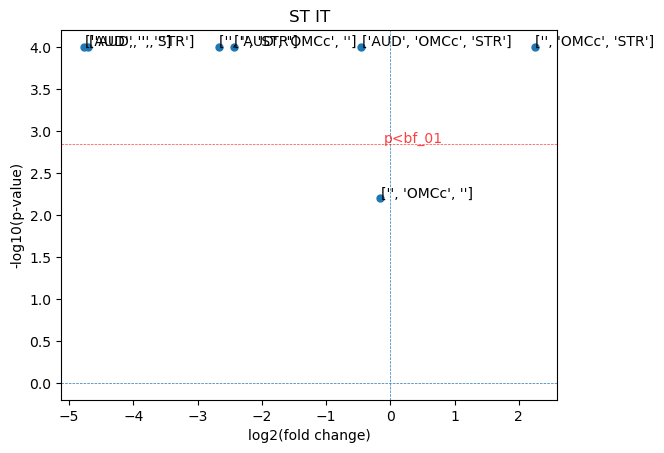

In [174]:
proportion_volcano_plot(end, title="ST IT", labels="labels", p_bf=bonferroni_corrected, p_05=False, p_01=False)

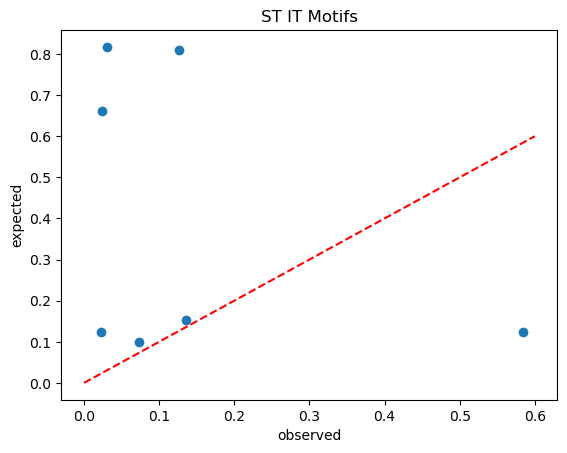

Original p-values: [0.006226404120237188, 0.0, 0.0, 1.6460232892866766e-110, 0.0, 0.0, 1.5088070830393566e-08]
Bonferroni corrected threshold: 0.0071428571428571435
Significant results: [True, True, True, True, True, True, True]


In [108]:

xy = np.linspace(0,0.6,5)
plt.scatter(end['obs'], end['exp'])
plt.plot(xy, xy, color='red', linestyle='--')
plt.xlabel("observed")
plt.ylabel("expected")
plt.title("ST IT Motifs")
plt.show()
# binomial test
import scipy.stats as stats

st_n = st_it_all.shape[0]

# Define your observed and expected fractions as arrays
observed_fractions = end['obs']  # Replace with your observed fractions
expected_fractions = end['exp']   # Replace with your expected fractions

# Perform a binomial test for each pair of observed and expected fractions
p_values = [stats.binom_test(obs * st_n, n=st_n, p=exp) for obs, exp in zip(observed_fractions, expected_fractions)]

# Apply Bonferroni correction to the p-values
alpha = 0.05  # Set your desired significance level
bonferroni_corrected = alpha / len(p_values)

# Check if any p-value is less than the Bonferroni corrected threshold
significant_results = [p < bonferroni_corrected for p in p_values]

# Print the original p-values and significant results
print("Original p-values:", p_values)
print("Bonferroni corrected threshold:", bonferroni_corrected)
print("Significant results:", significant_results)







In [150]:
import plotly.express as px
import plotly.graph_objects as go

# Create a scatter plot with labels
fig = px.scatter(end, x='obs', y='exp', text='labels')

# fig = go.Figure()
# fig.add_trace(go.Scatter(
#     x=end['obs'],
#     y=end['exp'],
#     mode='markers+text',
#     text=end['labels'],
#     hoverinfo='x+y+text',  # Show X, Y, and text on hover
#     textposition='top center'
# ))

# Set the label to be shown on hover
fig.update_traces(textposition='top center')

# add y=x
fig.add_trace(go.Scatter(x=[min(end['obs']), max(end['obs'])], y=[min(end['obs']), max(end['obs'])], mode='lines', name='y=x'))


# Customize the layout and specify figure dimensions
fig.update_layout(
    title="ST PT Motifs",
    xaxis_title="obs",
    yaxis_title="exp",
    width=800,  # Specify figure width
    height=600  # Specify figure height
)


# Show the plot
fig.show()



,obs,exp
0,0.135967,0.152044
1,0.031335,0.817166
2,0.126975,0.809537
3,0.022888,0.124245
4,0.584741,0.123085
5,0.024251,0.661526
6,0.073569,0.100581
